# Baseline model

Split the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
from xverse.feature_subset import SplitXY

def splitXY(df, target_column):

    clf = SplitXY([target_column]) #Split the dataset into X and y
    X, y = clf.fit_transform(df) #returns features (X) dataset and target(Y) as a numpy array
    return X, y

def make_train_test_split(X=None, y=None, test_size=0.3, random_state=1234):

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [4]:
selected_vars = ['V11', 'V12', 'V3', 'V19', 'V7', 'V14', 'V1', 'V4', 'V21', 'V2', 'V18', 'V16', 'V17', 'V9', 'V10']

# Build logistic regression model

In [5]:
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [6]:
def build_model(X, y):

    clf = LogisticRegression()
    clf.fit(X, y)
    return clf

In [7]:
def evaluate_model(clf, X, y):
    
    pred = clf.predict(X) #predicted classes
    accuracy = accuracy_score(pred,y) # calculate accuracy
    fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:,1]) # roc_curve
    auc_value = auc(fpr,tpr) # auc_value
    report = classification_report(y, pred, labels=[0,1], output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.reset_index()
    model_eval  = report_df[report_df['index'].str.contains('1')][['precision','recall','f1-score']]
    model_eval['accuracy']  = list(report_df[report_df['index'].str.contains('accuracy')]['support'])
    model_eval['ROC']  = auc_value
    cf_matrix = confusion_matrix(y, pred)
    
    return model_eval, cf_matrix

In [8]:
def model_eval_data(clf, X_train, y_train, 
                         X_test, y_test, 
                         model_eval_train, 
                         model_eval_test,
                         Name=None):
    
    temp_eval_train, cf_matrix_train = evaluate_model(clf, X_train, y_train)
    temp_eval_test, cf_matrix_test = evaluate_model(clf, X_test, y_test)
    temp_eval_train.index = [Name]
    temp_eval_test.index = [Name]
    
    try:
        model_eval_train = model_eval_train.append(temp_eval_train)
        model_eval_test = model_eval_test.append(temp_eval_test)
    except:
        model_eval_train = temp_eval_train
        model_eval_test = temp_eval_test
    
    return model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test

In [9]:
def make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test):
    
    plt.figure(1, figsize=(10,5))

    plt.subplot(121)
    sns.heatmap(cf_matrix_train, annot=True, yticklabels=['Not Fraud', 'Fraud'], 
                                xticklabels=['Not Fraud', 'Fraud'], fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,2])
    plt.title('Train data')

    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, yticklabels=['Not Fraud', 'Fraud'], 
                                xticklabels=['Not Fraud', 'Fraud'], fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,2])
    plt.tight_layout()
    plt.title('Test data')

    plt.tight_layout()
    return None

In [10]:
model_eval_train = pd.DataFrame({},[])
model_eval_test = pd.DataFrame({},[])

Using imbalanced data

In [11]:
X, y = splitXY(df, 'Class')
X_train, X_test, y_train, y_test = make_train_test_split(X=X, y=y, test_size=0.3, random_state=1)

In [12]:
X_train = X_train[selected_vars] #select the variables from variable selection proces
X_test = X_test[selected_vars]

In [14]:
clf = build_model(X_train, y_train)

In [15]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='imbalanced data - LogisticRegression')

In [16]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.897638,0.638655,0.746318,0.999223,0.974718


In [17]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.846154,0.57037,0.681416,0.999157,0.96878


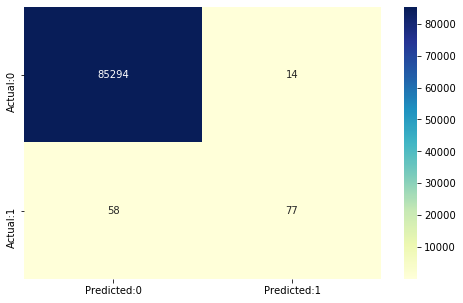

In [19]:
from sklearn.metrics import confusion_matrix
%matplotlib inline

y_pred = clf.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85308
           1       0.85      0.57      0.68       135

    accuracy                           1.00     85443
   macro avg       0.92      0.79      0.84     85443
weighted avg       1.00      1.00      1.00     85443



# Using imbalanced data without feature selection

In [29]:
X, y = splitXY(df, 'Class')
X_train, X_test, y_train, y_test = make_train_test_split(X=X, y=y, test_size=0.3, random_state=1)

In [21]:
clf1 = build_model(X_train, y_train)

C:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [22]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf1, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='imbalanced data - LogisticRegression(without FS)')

In [23]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.897638,0.638655,0.746318,0.999223,0.974718
imbalanced data - LogisticRegression(without FS),0.719764,0.683473,0.701149,0.998957,0.933974


In [24]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.846154,0.570370,0.681416,0.999157,0.968780
imbalanced data - LogisticRegression(without FS),0.705882,0.622222,0.661417,0.998993,0.881542


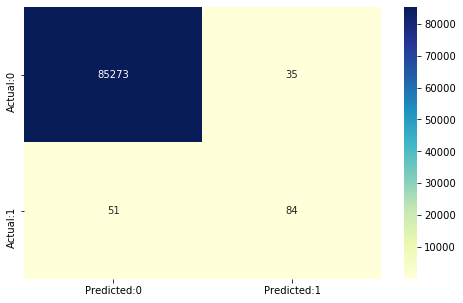

In [27]:
from sklearn.metrics import confusion_matrix
%matplotlib inline

y_pred = clf1.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85308
           1       0.71      0.62      0.66       135

    accuracy                           1.00     85443
   macro avg       0.85      0.81      0.83     85443
weighted avg       1.00      1.00      1.00     85443



# Randomsampling+Logistic regression

This is the baseline model using imbalanced data and simple logistic regression.

Then I will use the first sampling techniques on it: Random oversampling

In [30]:
from imblearn.over_sampling import RandomOverSampler

In [31]:
X, y = splitXY(df, 'Class')
X_train, X_test, y_train, y_test = make_train_test_split(X=X, y=y, test_size=0.3, random_state=1)
X_train = X_train[selected_vars] #select the variables from variable selection proces
X_test = X_test[selected_vars]

In [32]:
X_resampled, y_resampled = RandomOverSampler().fit_sample(X_train, y_train)

In [33]:
clf2 = build_model(X_resampled, y_resampled)

In [34]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf2, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='RandomOversampling data')

In [35]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.897638,0.638655,0.746318,0.999223,0.974718
imbalanced data - LogisticRegression(without FS),0.719764,0.683473,0.701149,0.998957,0.933974
RandomOversampling data,0.084492,0.901961,0.154511,0.982324,0.979848


In [36]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.846154,0.570370,0.681416,0.999157,0.968780
imbalanced data - LogisticRegression(without FS),0.705882,0.622222,0.661417,0.998993,0.881542
RandomOversampling data,0.074192,0.866667,0.136682,0.982702,0.981411


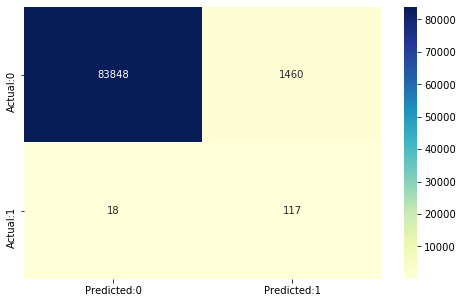

In [38]:
from sklearn.metrics import confusion_matrix
%matplotlib inline

y_pred = clf2.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85308
           1       0.07      0.87      0.14       135

    accuracy                           0.98     85443
   macro avg       0.54      0.92      0.56     85443
weighted avg       1.00      0.98      0.99     85443



# Smote-logisticregression

In [40]:
from imblearn.over_sampling import SMOTE
#from sklearn.model_selection import GridSearchCV

In [41]:
X, y = splitXY(df, 'Class')
X_train, X_test, y_train, y_test = make_train_test_split(X=X, y=y, test_size=0.3, random_state=0)
X_train = X_train[selected_vars] #select the variables from variable selection proces
X_test = X_test[selected_vars]

In [42]:
smote = SMOTE(random_state=5)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

In [43]:
clf3 = build_model(X_sm, y_sm)

In [45]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf3, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='SMOTE - LogisticRegression')

In [46]:
y_pred = clf3.predict(X_test)

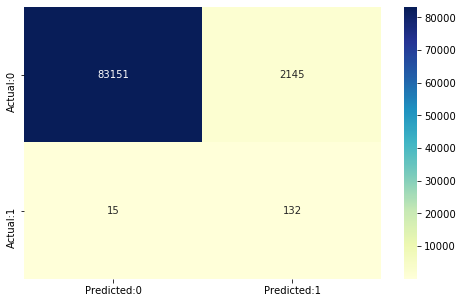

In [47]:
from sklearn.metrics import confusion_matrix
%matplotlib inline

y_pred = clf3.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [48]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.897638,0.638655,0.746318,0.999223,0.974718
imbalanced data - LogisticRegression(without FS),0.719764,0.683473,0.701149,0.998957,0.933974
RandomOversampling data,0.084492,0.901961,0.154511,0.982324,0.979848
SMOTE - LogisticRegression,0.057586,0.904348,0.108277,0.974223,0.980405


In [49]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.846154,0.570370,0.681416,0.999157,0.968780
imbalanced data - LogisticRegression(without FS),0.705882,0.622222,0.661417,0.998993,0.881542
RandomOversampling data,0.074192,0.866667,0.136682,0.982702,0.981411
SMOTE - LogisticRegression,0.057971,0.897959,0.108911,0.974720,0.977955


In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85296
           1       0.06      0.90      0.11       147

    accuracy                           0.97     85443
   macro avg       0.53      0.94      0.55     85443
weighted avg       1.00      0.97      0.99     85443



# Borderline-Smote+Logistic Regression

In [51]:
from imblearn.over_sampling import BorderlineSMOTE

In [52]:
X, y = splitXY(df, 'Class')
X_train, X_test, y_train, y_test = make_train_test_split(X=X, y=y, test_size=0.3, random_state=1)
X_train = X_train[selected_vars] #select the variables from variable selection proces
X_test = X_test[selected_vars]

In [53]:
bsm = BorderlineSMOTE(random_state=1,kind="borderline-1")

In [54]:
X_bsm, y_bsm = bsm.fit_resample(X_train, y_train)

In [55]:
clf5 = build_model(X_bsm, y_bsm)

In [56]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf5, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='Borderline-SMOTE - LogisticRegression')

In [57]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.897638,0.638655,0.746318,0.999223,0.974718
imbalanced data - LogisticRegression(without FS),0.719764,0.683473,0.701149,0.998957,0.933974
RandomOversampling data,0.084492,0.901961,0.154511,0.982324,0.979848
SMOTE - LogisticRegression,0.057586,0.904348,0.108277,0.974223,0.980405
Borderline-SMOTE - LogisticRegression,0.172622,0.879552,0.288603,0.992235,0.948088


In [58]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.846154,0.570370,0.681416,0.999157,0.968780
imbalanced data - LogisticRegression(without FS),0.705882,0.622222,0.661417,0.998993,0.881542
RandomOversampling data,0.074192,0.866667,0.136682,0.982702,0.981411
SMOTE - LogisticRegression,0.057971,0.897959,0.108911,0.974720,0.977955
Borderline-SMOTE - LogisticRegression,0.147175,0.829630,0.250000,0.992135,0.933410


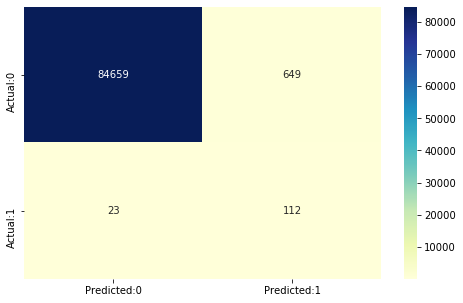

In [59]:
from sklearn.metrics import confusion_matrix
%matplotlib inline

y_pred = clf5.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85308
           1       0.15      0.83      0.25       135

    accuracy                           0.99     85443
   macro avg       0.57      0.91      0.62     85443
weighted avg       1.00      0.99      0.99     85443



ADASYN

In [61]:
from imblearn.over_sampling import ADASYN 

In [62]:
X, y = splitXY(df, 'Class')
X_train, X_test, y_train, y_test = make_train_test_split(X=X, y=y, test_size=0.3, random_state=1)
X_train = X_train[selected_vars] #select the variables from variable selection proces
X_test = X_test[selected_vars]

In [63]:
ada = ADASYN()
adaX, aday = ada.fit_sample(X_train, y_train)

In [64]:
clf4 = build_model(adaX, aday)

In [65]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf4, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='ADASYN LogisticRegression')

In [66]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.897638,0.638655,0.746318,0.999223,0.974718
imbalanced data - LogisticRegression(without FS),0.719764,0.683473,0.701149,0.998957,0.933974
RandomOversampling data,0.084492,0.901961,0.154511,0.982324,0.979848
SMOTE - LogisticRegression,0.057586,0.904348,0.108277,0.974223,0.980405
Borderline-SMOTE - LogisticRegression,0.172622,0.879552,0.288603,0.992235,0.948088
ADASYN LogisticRegression,0.016206,0.949580,0.031868,0.896686,0.980474


In [67]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.846154,0.570370,0.681416,0.999157,0.968780
imbalanced data - LogisticRegression(without FS),0.705882,0.622222,0.661417,0.998993,0.881542
RandomOversampling data,0.074192,0.866667,0.136682,0.982702,0.981411
SMOTE - LogisticRegression,0.057971,0.897959,0.108911,0.974720,0.977955
Borderline-SMOTE - LogisticRegression,0.147175,0.829630,0.250000,0.992135,0.933410
ADASYN LogisticRegression,0.014520,0.962963,0.028609,0.896680,0.982796


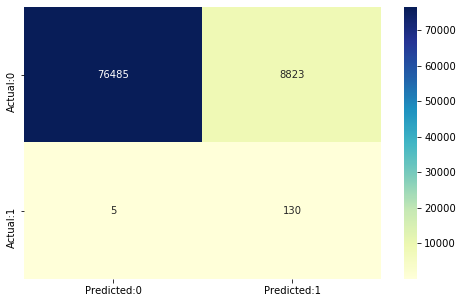

In [68]:
from sklearn.metrics import confusion_matrix
%matplotlib inline

y_pred = clf4.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     85308
           1       0.01      0.96      0.03       135

    accuracy                           0.90     85443
   macro avg       0.51      0.93      0.49     85443
weighted avg       1.00      0.90      0.94     85443



# Comparison of different models

In [70]:
final_eval_test = model_eval_test.copy(deep=True)

In [71]:
model_eval_test.reset_index(inplace=True)

In [72]:
model_eval_test.rename({'index': 'Method'}, axis=1, inplace=True)

General Result

In [73]:
model_eval_test

,Method,precision,recall,f1-score,accuracy,ROC
0,imbalanced data - LogisticRegression,0.846154,0.570370,0.681416,0.999157,0.968780
1,imbalanced data - LogisticRegression(without FS),0.705882,0.622222,0.661417,0.998993,0.881542
2,RandomOversampling data,0.074192,0.866667,0.136682,0.982702,0.981411
3,SMOTE - LogisticRegression,0.057971,0.897959,0.108911,0.974720,0.977955
4,Borderline-SMOTE - LogisticRegression,0.147175,0.829630,0.250000,0.992135,0.933410
5,ADASYN LogisticRegression,0.014520,0.962963,0.028609,0.896680,0.982796


In [74]:
tidy = model_eval_test.melt(id_vars='Method').rename(columns=str.title)

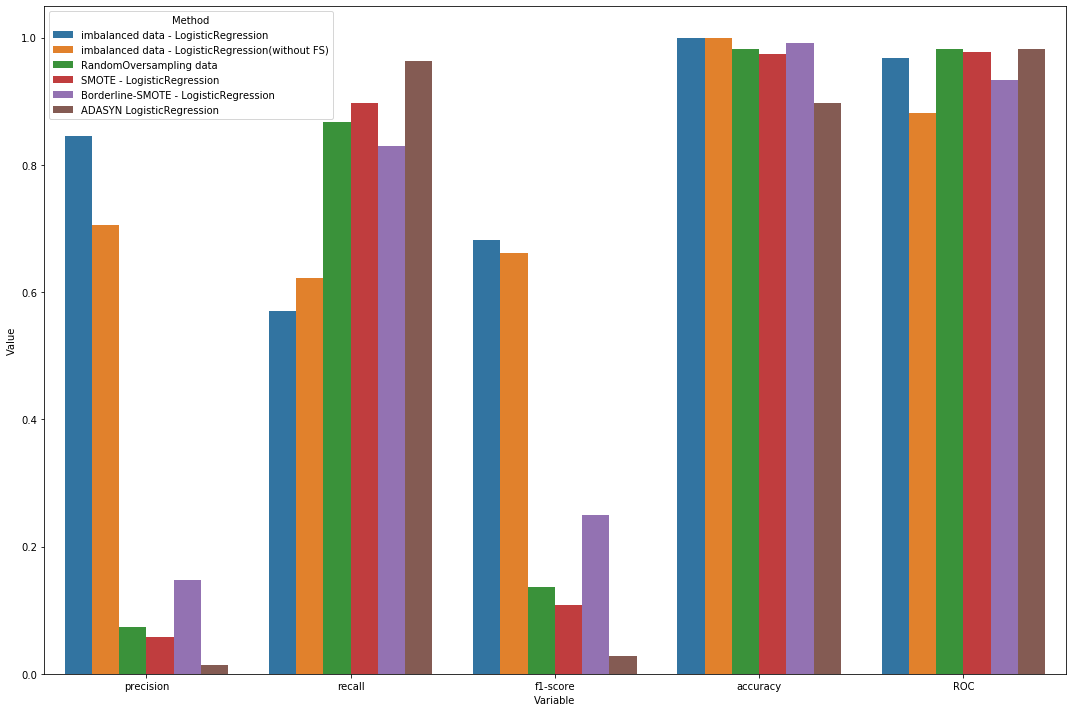

In [75]:
plt.figure(figsize=(15,10))
sns.barplot(x='Variable', y='Value', hue='Method', data=tidy)
plt.tight_layout()

Focus on Minority